## Mount to gdrive to read data, adjacency matrix, p_link and labels. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data which are processed in preprocessing_data_7classes.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/7classes.sim/data_7classes.pt"
Data = torch.load(path)
Data

{'x': tensor([[-0.6680,  0.3545,  0.1382,  ...,  2.1196,  0.2813,  1.3384],
         [ 0.0282,  1.6481,  1.9474,  ...,  0.8241,  0.9470,  1.9798],
         [-0.4644,  0.5799,  0.0618,  ..., -0.5351, -0.2698,  0.9294],
         ...,
         [-0.2195, -0.8809,  0.0466,  ..., -0.5610,  2.1045, -0.2778],
         [-0.7321,  0.0596,  1.4736,  ...,  0.7870,  0.7216, -1.5205],
         [ 1.0196,  0.5744,  0.3943,  ...,  1.7039, -1.3692,  0.6619]]),
 'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  4,
           4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
           6,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
           9, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 16, 16,
          17, 17, 17, 18, 18, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21,
          21, 21, 22, 22, 22, 22, 23, 24, 24, 24, 24, 25, 25, 26, 26, 26, 26, 27,
          27, 27, 28, 28, 29, 29, 29, 30, 30, 3

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 70
Number of features: 500
Number of classes: 7
Number of edges: 260
Average node degree: 3.71
Number of training nodes: 21
Number of testing nodes: 39
Training node label rate: 0.30


# Install torch_geometic

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 2.7 MB/s 
     |████████████████████████████████| 4.6 MB 2.8 MB/s 
     |████████████████████████████████| 280 kB 4.6 MB/s 


In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = GATConv(in_channels = 500, out_channels = 50)
        self.conv2 =  GATConv(50, 10)
        self.conv3 =  GATConv(10, 7)
        

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.torch.tanh(h)
        h = self.conv3(h, edge_index)# Final GNN embedding space.
        h = F.log_softmax(h)
        return h
        

model = Myconv()
print(model)
print(model.forward(Data["x"], Data["edge_index"]))

Myconv(
  (conv1): GATConv(500, 50, heads=1)
  (conv2): GATConv(50, 10, heads=1)
  (conv3): GATConv(10, 7, heads=1)
)
tensor([[-2.4665, -2.1269, -2.5751, -1.0695, -1.9733, -1.8291, -2.5636],
        [-1.8347, -2.6898, -2.3343, -2.1443, -1.2235, -2.2313, -1.8525],
        [-1.7384, -2.0836, -2.0600, -1.8335, -1.9923, -1.9708, -1.9902],
        [-1.6594, -2.1520, -1.9603, -1.3046, -2.4086, -2.3315, -2.3610],
        [-1.9883, -2.0943, -2.3361, -1.6303, -1.9120, -1.7473, -2.0770],
        [-1.6118, -2.5256, -2.4606, -1.6407, -1.6896, -1.9180, -2.2097],
        [-1.8169, -1.7161, -2.2494, -2.0461, -2.2622, -1.8042, -1.8689],
        [-2.1201, -2.3137, -1.9353, -1.6325, -1.7257, -1.7829, -2.3532],
        [-1.8635, -1.6950, -2.2745, -2.0713, -2.2583, -1.7564, -1.8630],
        [-2.0157, -1.7854, -2.4848, -1.8401, -2.0994, -1.6568, -1.9406],
        [-2.0922, -2.0198, -2.5697, -1.3342, -2.1416, -1.8899, -1.9993],
        [-1.9327, -2.5701, -2.1212, -1.4091, -1.7320, -1.9227, -2.3935],
      

<ipython-input-7-92bb1eef0b9a>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


# We take a look at the node embeddings produced by GAT (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 150)
    sns.scatterplot(z[:, 0], z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",7)).set(title = "Second scenario data T-SNE projection before training (GAT)")

<ipython-input-7-92bb1eef0b9a>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Embedding shape: [70, 7]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


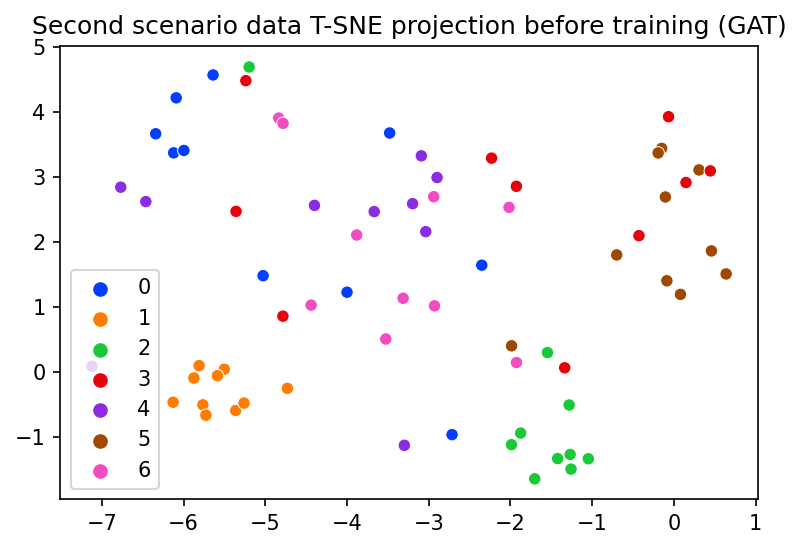

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model. 

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        #pred = out.argmax(dim=1)
        #test_correct = pred[Data["val_mask"]] == Data["y"][Data["val_mask"]]  # Check against ground-truth labels.
        #test_acc = int(test_correct.sum()) / int(Data["val_mask"].sum())  # Derive ratio of correct predictions.
        return val_loss

In [ ]:
train_loss_ = []
val_loss_ = []

for epoch in range(1, 101):

  epoch_train_loss = []
  epoch_val_loss = []
  train_loss = train(Data)
  val_loss = val(Data)






  epoch_train_loss.append(train_loss.item())
  epoch_val_loss.append(val_loss.item())




  

  val_loss_.append(sum(epoch_val_loss)/len(epoch_val_loss))
  train_loss_.append(sum(epoch_train_loss)/len(epoch_train_loss))
  print(epoch,'Train Loss: %.3f | val Loss: %.3f'%( train_loss,val_loss))

<ipython-input-7-92bb1eef0b9a>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


1 Train Loss: 2.105 | val Loss: 1.849
2 Train Loss: 1.922 | val Loss: 1.664
3 Train Loss: 1.786 | val Loss: 1.595
4 Train Loss: 1.701 | val Loss: 1.544
5 Train Loss: 1.632 | val Loss: 1.500
6 Train Loss: 1.566 | val Loss: 1.462
7 Train Loss: 1.501 | val Loss: 1.436
8 Train Loss: 1.447 | val Loss: 1.415
9 Train Loss: 1.397 | val Loss: 1.392
10 Train Loss: 1.350 | val Loss: 1.369
11 Train Loss: 1.307 | val Loss: 1.349
12 Train Loss: 1.264 | val Loss: 1.331
13 Train Loss: 1.223 | val Loss: 1.316
14 Train Loss: 1.185 | val Loss: 1.303
15 Train Loss: 1.151 | val Loss: 1.292
16 Train Loss: 1.122 | val Loss: 1.282
17 Train Loss: 1.097 | val Loss: 1.274
18 Train Loss: 1.074 | val Loss: 1.266
19 Train Loss: 1.052 | val Loss: 1.258
20 Train Loss: 1.031 | val Loss: 1.248
21 Train Loss: 1.010 | val Loss: 1.238
22 Train Loss: 0.989 | val Loss: 1.227
23 Train Loss: 0.969 | val Loss: 1.215
24 Train Loss: 0.949 | val Loss: 1.203
25 Train Loss: 0.930 | val Loss: 1.192
26 Train Loss: 0.912 | val Loss: 1

# Visualize train loss and val loss.

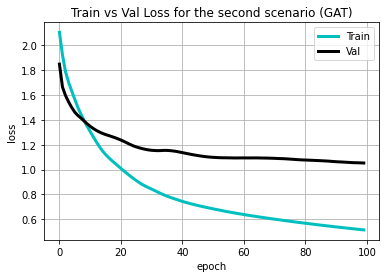

In [ ]:
plt.plot(train_loss_, "c", linewidth = 3)
plt.plot(val_loss_, "k", linewidth = 3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the second scenario (GAT)')
plt.grid()
plt.show()

# Compute the accuracy of the model.

In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out= model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim=1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc

In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc:.2f}')

Test Accuracy: 74.36


<ipython-input-7-92bb1eef0b9a>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


# We take a look at the node embeddings produced by GAT (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 150)
    sns.scatterplot(z[:, 0], z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",7)).set(title = "Second scenario data T-SNE projection after training (GAT)")

<ipython-input-7-92bb1eef0b9a>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


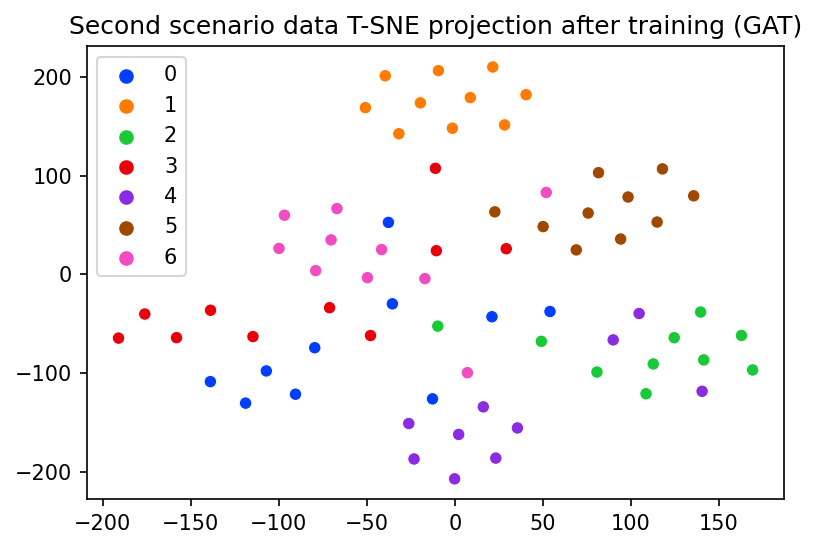

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred = out.argmax(dim=1)
pred

tensor([2, 5, 6, 6, 6, 6, 1, 4, 1, 1, 6, 4, 5, 0, 1, 5, 6, 4, 5, 5, 1, 5, 4, 6,
        2, 0, 2, 3, 2, 4, 4, 6, 1, 0, 3, 4, 2, 3, 0, 5, 2, 1, 0, 5, 2, 1, 2, 4,
        2, 6, 4, 5, 4, 1, 2, 1, 2, 0, 0, 3, 3, 1, 5, 5, 3, 2, 5, 6, 2, 0])

In [ ]:
pred = pred[Data["test_mask"]] 

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted':pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,0,2
1,5,5
2,6,6
3,3,6
4,1,1
5,4,4
6,6,6
7,0,4
8,3,5
9,5,5


<ipython-input-21-e98e59ef199f>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


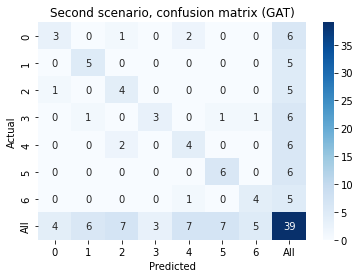

In [ ]:
confusion_matrix = pd.crosstab(data['y_Actual'], data['y_Predicted'], rownames=['Actual'], colnames = ['Predicted'], margins = True)
import seaborn as sn
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues")
ax = plt.axes()
ax.set_title('Second scenario, confusion matrix (GAT)')
plt.show()